## Geneshot Predicted Gene Drug-Set Library
### Drug-set labels: Genes
#### ALL DATABASES ACCESSED 04/2020
##### Author : Eryk Kropiwnicki | eryk.kropiwnicki@icahn.mssm.edu

In [1]:
import csv
import time 
import requests
import json
from collections import defaultdict
import pandas as pd
import numpy as np
import os

In [2]:
os.chdir('../../scripts')
from export_script import *
from gene_resolver import *
os.chdir('../notebooks/Geneshot')

#### Input file : geneshot_drug_genesetlibrary.txt (generated from Geneshot Associated Gene Drugsetlibrary.ipynb)

In [3]:
with open('input/geneshot_drug_genesetlibrary.txt', 'r') as f:
    reader = csv.reader(f, delimiter = '\t')
    # Formatting dictionary values to be compatible with Geneshot API
    genedict = {str(row[0]):(','.join([str(g)for g in row[2:]if g != ''])) for row in reader}

In [4]:
len(genedict)

3938

In [5]:
# List of all drugs
drugs = []
for k,v in genedict.items():
    drugs.append(k)

### Querying each small molecule genelist through Geneshot API

In [6]:
GENESHOT_URL = 'http://amp.pharm.mssm.edu/geneshot/api'
query_string = '/associate/%s/%s'
similarity_matrix = ['autorif','enrichr','generif','tagger','coexpression']

In [ ]:
for matrix in similarity_matrix:
    feeds = []
    with open("input/"+matrix+"_predicted_genes.json", "w") as outfile:
        for drug, genelist in genedict.items():
            response = requests.get(
                GENESHOT_URL + query_string % (matrix,genelist)
            )
            data = response.json()
            data[drug] = data.pop("association")
            feeds.append(data)
            time.sleep(0.5)
        json.dump(feeds, outfile, indent = 4)
        outfile.close()

### Creating drugsetlibraries for each similarity matrix query

In [9]:
# Function for converting each json file into drugsetlibrary

def drugsetlibrary_converter(similarity_matrix):
    with open ('input/'+similarity_matrix+'_predicted_genes.json') as data_file:
        data = json.load(data_file)
    
    # Iterate through json object and retrieve compounds matched to genes and similarity scores
    df = pd.DataFrame()

    simscores = []
    drug_list = []
    gene_list = []

    for drug in drugs:
        for item in data:
            if drug in item:
                for gene in item[drug]:
                    simscores.append((item[drug][gene]["simScore"]))
                    drug_list.append(drug)
                    gene_list.append(gene)

    df['Compound'] = drug_list 
    df['Gene_name'] = gene_list
    df['Similarity_score'] = simscores
    
    # Retrieve approved symbols for all genes
    unique_genes = list(set(df['Gene_name'].tolist()))

    approved_symbols = gene_resolver(unique_genes,fmt='list') # resolve genes using gene_resolver script
    
    df = df.merge(approved_symbols) # merge approved symbols back onto main dataframe
    
    # Filter each gene by top 1000 small molecule associations by similarity score
    df_filtered = df.sort_values(by = ['Approved Symbol', 'Similarity_score'], ascending = False)\
        .groupby('Approved Symbol')\
        .head(1000)
    
    # Create drugsetlibrary
    genes = df_filtered['Approved Symbol'].tolist()
    compounds = df_filtered['Compound'].tolist()

    id_list = tuple(zip(genes,compounds))
    drugsetlibrary = defaultdict(list)
    for k,v in id_list:
        drugsetlibrary[k].append(v)

    drugsetlibrary = {k:list(set(v)) for k,v in drugsetlibrary.items() if len(set(v)) >=5}
    
    # Creating histogram of drug-set sizes
    %matplotlib inline
    import matplotlib.pyplot as plt
    import numpy as np
    from pylab import figure, text, scatter, show

    df_setsize = pd.DataFrame(columns = ['Gene','Drugset_size'])
    genes = []
    drugset = []
    for k,v in drugsetlibrary.items():
        genes.append(k)
        drugset.append(len(set(v)))
    df_setsize['Gene'] = genes
    df_setsize['Drugset_size'] = drugset

    plt.figure()
    plt.hist(df_setsize['Drugset_size'].values, bins=100)
    plt.xlabel('Drugset size')
    plt.ylabel('Counts')
    plt.title('Histogram of drugset size per gene')
    plt.yscale('log')
    plt.axvline(np.mean(df_setsize['Drugset_size']), color='red', label='mean')
    plt.axvline(np.median(df_setsize['Drugset_size']), color='black', label='median')
    plt.legend()
    plt.show()
        
    
    # Printing library counts
    print(similarity_matrix)
    library_counts(drugsetlibrary)
    
    # Exporting drugsetlibrary 
    gmt_formatter(drugsetlibrary, '../../data/Geneshot/Geneshot_predicted_'+similarity_matrix+'_drugsetlibrary.gmt')

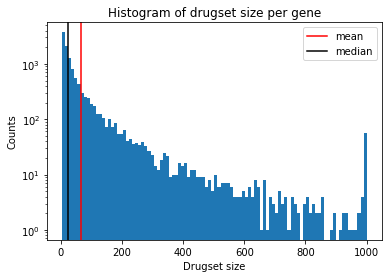

autorif
3938 unique drugs
11695 unique association terms
772329 unique associations
66.03924754168447 average drugs per term


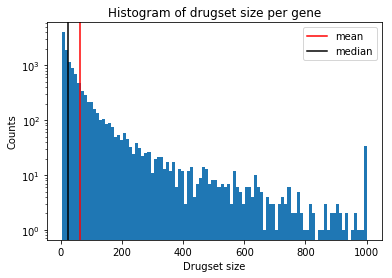

enrichr
3938 unique drugs
11845 unique association terms
734799 unique associations
62.03452933727311 average drugs per term


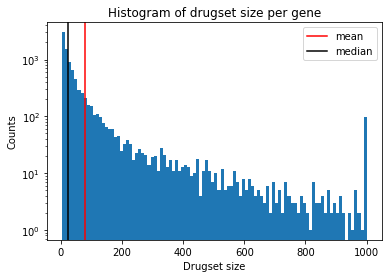

generif
3938 unique drugs
9193 unique association terms
723077 unique associations
78.65517241379311 average drugs per term


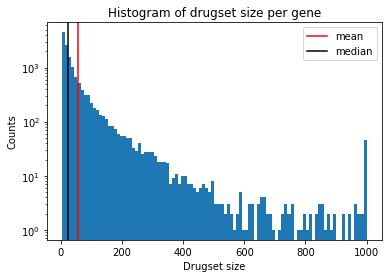

tagger
3938 unique drugs
13882 unique association terms
771849 unique associations
55.60070595015127 average drugs per term


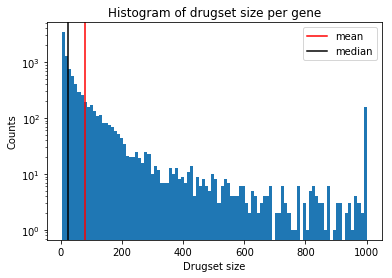

coexpression
3938 unique drugs
9087 unique association terms
717497 unique associations
78.95862220754924 average drugs per term


In [10]:
for term in similarity_matrix:
    drugsetlibrary_converter(term)